In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scipy


Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Import libraries, packages, modules, functions, etc...
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import skimage
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, unsupervised_wiener
from scipy.signal import convolve2d as conv2
from skimage.filters import median
import copy
from tqdm import tqdm
from scipy import ndimage as nd
import multiprocessing
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from itertools import repeat
import zipfile
import os
from IPython.display import FileLink
from sklearn.svm import SVC
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from skimage.morphology import disk
from tensorflow.keras.optimizers import SGD
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install natsort


Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install MedPy

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import natsort
from medpy.filter.smoothing import anisotropic_diffusion
%matplotlib inline


In [5]:
# Get the complete data of kidney stone images
import os
def Get_data(dir, catagories, data):
    for category in catagories:
        path = os.path.join(dir, category)
        class_number = catagories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                new_image = cv2.resize(img_array,(128,128))
                data.append([new_image , class_number])
            except Exception as e:
                pass

data = []
# Augmented Dataset
# Get_data("/kaggle/input/combined-aug-ks/KS_Detection", ["Combined_N", "Combined_KS"], data)

# Original Dataset
Get_data("C:/Users/Akshay Bhagwat/Desktop/projects/DIP/Dataset", ["Kidney_stone", "Normal"], data)

In [6]:
catagories = ["Kidney_stone", "Normal"]
print(catagories.index("Kidney_stone"))
print(catagories.index("Normal"))

0
1


In [7]:
print('Number of kidney stone images',len(os.listdir('C:/Users/Akshay Bhagwat/Desktop/projects/DIP/Dataset/Kidney_stone')))
print('Number of Normal kidney images',len(os.listdir('C:/Users/Akshay Bhagwat/Desktop/projects/DIP/Dataset/Normal')))


Number of kidney stone images 625
Number of Normal kidney images 828


(128, 128, 3)


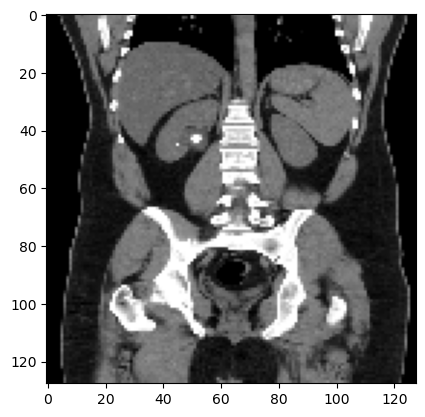

In [8]:
print(data[1][0].shape)
plt.imshow(data[1][0])
plt.show()

In [9]:
# Extract Features and Labels from the data
Features = []
Labels = []
for features , labels in data:
    Features.append(features)
    Labels.append(labels)
Features = np.array(Features)
Labels = np.array(Labels)


In [11]:
Features[1][:,:,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
# Shape of Features and Labels
print(Features.shape)
print(Labels.shape)

(1453, 128, 128, 3)
(1453,)


In [13]:
print("PREPROCESSING")

PREPROCESSING


In [14]:
def Processed(Processed_images):
    img_per_row = 3
    fig, ax = plt.subplots(nrows = 2, ncols = img_per_row, figsize=(10,10), subplot_kw = dict(xticks = [], yticks = []))
    for row in [0, 1]:
        for col in range(img_per_row):
            if(row * img_per_row + col == 7):
                break
            if(Processed_images[row * img_per_row + col][1] == "Bilateral_Denoised" or Processed_images[row * img_per_row + col][1] == "Wavelet_Denoised" or Processed_images[row * img_per_row + col][1] == "Non_Local_Means"):
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('float64'), cmap = "gray")
            else:
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('uint8'), cmap = "gray")
            ax[row, col].set_title(Processed_images[row * img_per_row + col][1])
            plt.axis('off')
    plt.show()

In [15]:
# Efficient in reducing gaussian image
# Lowers the image resolution
def AnisotropicFilter_wholedataset(noised_dataset, niter, kappa, gamma, option, size):
    anisotropic_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(anisotropic_dataset.shape[0])):
        anisotropic_dataset[i] = anisotropic_diffusion(noised_dataset[i,:,:,:][:,:,0], niter=niter, kappa=kappa, gamma=gamma, option=option).reshape(size, size, 1)
    return anisotropic_dataset



# Reduce spiky noise
# Non linear filter
# Smoothens the image
# Prevent blur and preserve sharp edges 
# Only better for removing salt and pepper noise
def median_wholedataset(noised_dataset, filtersize, size):
    median_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        median_wholedata[i] = median(noised_dataset[i,:,:,:][:,:,0], np.ones((filtersize, filtersize))).reshape(size, size, 1)
    return median_wholedata


# Regardless of the frequency composition of the signal, eliminate noise while keeping its properties 
# Unable to preserve fine details in case of high noise data.
# There's a chance the wavelet coefficients are biased
def wavelet_wholedataset(noised_dataset, sigma, wavelet_levels, size):
    wavelet_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        wavelet_wholedata[i] = denoise_wavelet(noised_dataset[i,:,:,:], sigma=sigma, channel_axis=-1, wavelet_levels=wavelet_levels, rescale_sigma=True).reshape(size, size, 1)
    return wavelet_wholedata


# Better in preserving edges
# Effectively remove gaussian noise
# Not the best fit for salt and pepper noise
def BilateralFilter_wholedataset(noised_dataset, sigma_color, sigma_spatial, channel_axis, size):
    bilateral_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(bilateral_dataset.shape[0])):
        bilateral_dataset[i] = denoise_bilateral(noised_dataset[i, :, :, :], sigma_color = sigma_color, sigma_spatial=sigma_spatial, channel_axis=channel_axis).reshape(size, size, 1)
    return bilateral_dataset


# Effect for gaussian noise
# Simplicity of algorithm is one of the pros
# Reduce the image details
# Unable to preserve edges
# Denoised images would be blurry.
def GaussianFilter_wholedataset(noised_dataset, sigma):
    gaussian_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(gaussian_dataset.shape[0])):
        gaussian_dataset[i] = nd.gaussian_filter(tuple(noised_dataset[i, :, :, :]), sigma=sigma)
    return gaussian_dataset


# Preserve edges
# Better performance with redundant images
# Expensive, so non-suggestable for larger noise
def non_local_mean(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))
    patch_kw = dict(patch_size = 5,      # 5x5 patches
                patch_distance = 6,  # 13x13 search area
                channel_axis = -1)
    denoise_fast = denoise_nl_means(image, h = 0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)
    return denoise_fast


# Apply bilateral filter with d = 15
# sigmaColor = sigmaSpace = 75
# d: Diameter of each pixel neighborhood.
# sigmaColor: Value of sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.
# sigmaSpace: Value of sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.
def cv2bilateralFilter(image, d, sigmaColor, sigmaSpace):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    bilateral = bilateral.astype('uint8')
    return bilateral




# Execution
# ani = AnisotropicFilter_wholedataset(noised_dataset, 50, 20, 0.2, 1)
# bi = BilateralFilter_wholedataset(noised_dataset, 15, -1)
# gauss = GaussianFilter_wholedataset(noised_dataset, 2)

# median_img = median(Features[0, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
# wavelet_img = denoise_wavelet(Features[0, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True).reshape(128, 128, 3)
# bilateral_image = denoise_bilateral(Features[0], sigma_spatial = 10, channel_axis = -1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 100, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 50, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[60,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.005, option=1)
# anisotropic_image = anisotropic_diffusion(Features[600,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.000001, option=1)
# anisotropic_image = anisotropic_image.astype('uint8')


# Metrics
def psnr_wholedataset(dataset_original, dataset_denoised):

    sumpsnr = 0
    avgpsnr = 0
    for i in tqdm(range(dataset_original.shape[0])):
        true_min, true_max = np.min(dataset_original[i, :, :, :]), np.max(dataset_original[i, :, :, :])
        dataRange = abs(true_min)+abs(true_max)
        psnr = peak_signal_noise_ratio(dataset_original[i], dataset_denoised[i], data_range=dataRange)
        sumpsnr += psnr
    avgpsnr = sumpsnr/dataset_original.shape[0]     

    return avgpsnr

# psnr_wholedataset(data, noised_dataset)


# Execution
# true_min, true_max = np.min(Features[0]), np.max(Features[0])
# dataRange = abs(true_min) + abs(true_max)
# print("PSNR: ", peak_signal_noise_ratio(Features[143, :, :, :][:,:,0], anisotropic_image, data_range = dataRange))
# print("MSE: ", mean_squared_error(Features[143,:,:,:][:,:,0], anisotropic_image))
# print("SSIM: ", ssim(Features[143, :, :, :][:,:,0], anisotropic_image, multichannel=True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))


# plt.imshow(np.hstack((wavelet_img, Features[143, :, :, :].reshape(128,128,3))), cmap = "gray")

In [16]:
true_min, true_max = np.min(Features[1]), np.max(Features[1])
dataRange = abs(true_min) + abs(true_max)
bilateral = cv2bilateralFilter(Features[1,:,:,:], 15, 75, 75)
print("PSNR: ", peak_signal_noise_ratio(Features[1,:,:,:], bilateral, data_range = dataRange))
print("MSE: ", mean_squared_error(Features[1,:,:,:], bilateral))
print("SSIM: ", ssim(Features[1,:,:,:], bilateral, multichannel = True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))

PSNR:  30.78883928755087
MSE:  54.224609375
SSIM:  0.9118347070339125


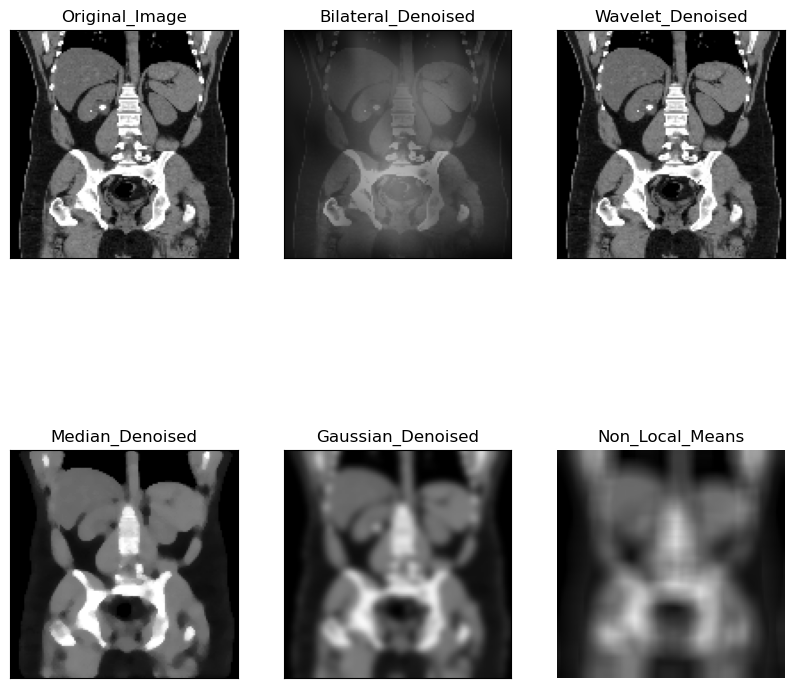

In [17]:
#anisotropic_image = anisotropic_diffusion(Features[1], niter = 50, kappa = 5, gamma = 0.005, option=1)
bilateral_image = denoise_bilateral(Features[1], sigma_spatial = 10, channel_axis = -1)
wavelet_img = denoise_wavelet(Features[1, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr = True, method = 'BayesShrink', mode = 'soft', rescale_sigma = True).reshape(128, 128, 3)
median_img = median(Features[1, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
guassian_img = nd.gaussian_filter(tuple(Features[1, :, :, :]), sigma = 2)
non_local_mean_img = non_local_mean(Features[1])

Processed_images = [[Features[1, :, :, :], "Original_Image"], [bilateral_image, "Bilateral_Denoised"], [wavelet_img, "Wavelet_Denoised"], [median_img,"Median_Denoised"], [guassian_img, "Gaussian_Denoised"], [non_local_mean_img, "Non_Local_Means"]]

Processed(Processed_images)

In [19]:
Processed_images = [[Features[143, :, :, :], "Original_Image"], [bilateral_image, "Bilateral_Denoised"], [wavelet_img, "Wavelet_Denoised"], [median_img,"Median_Denoised"], [guassian_img, "Gaussian_Denoised"], [non_local_mean_img, "Non_Local_Means"]]


In [58]:
#Cropping, Thersholding(or masking), Edge Detection, Morphological Analysis

In [20]:
def crop(image_to_be_cropped):
    height, width = image_to_be_cropped.shape[:2]
    start_row, start_col = int(height * .24), int(width * .24)
    end_row, end_col = int(height * .78), int(width * .78)
#     start_row, start_col = int(height * .24), int(width * .24)
#     end_row, end_col = int(height * .42), int(width * .78)
    cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
    return cropped_image

def threshold(img, thresh1 = 254):
    return ((img > thresh1) * 255).astype('uint8')


# Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. 
def edge_detection(Image):
    img = cv2.Canny(Image, 100, 200)
    return img

# To see the pixel values division in the images
def hist_plot(Image):
    plt.hist(Image.flat, bins = 100, range = (0, 255))
    plt.show()

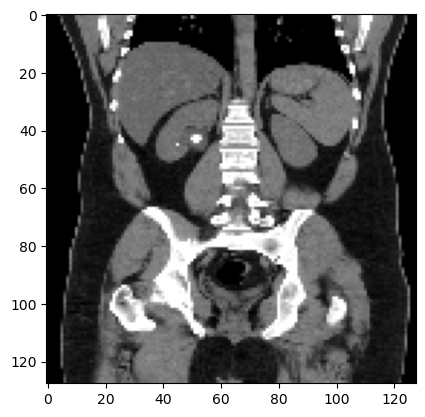

In [22]:
# Convert BGR image to Gray Scale image
gray_image = cv2.cvtColor(data[1][0], cv2.COLOR_BGR2GRAY)

# expanding dimensions from 128,128 to 128,128,1
gray_image = np.expand_dims(gray_image, axis = -1)

plt.imshow(gray_image, cmap = "gray")
plt.show()

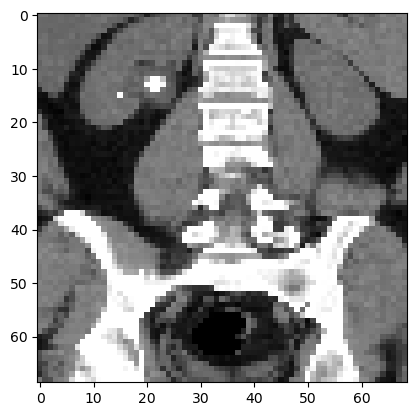

In [23]:
# Crop a Image
cropped_image = crop(Features[1,:,:,:])
plt.imshow(cropped_image)
plt.show()

In [24]:
cropped_image.shape

(69, 69, 3)

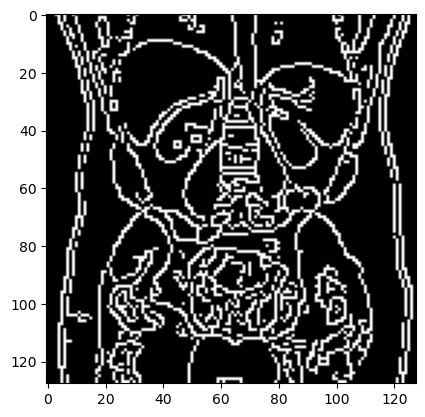

In [25]:
# Edge Detection
img = edge_detection(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

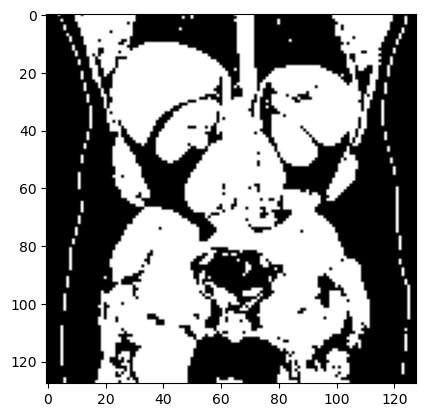

In [26]:
# Threshold masking using OTSU method
# Automatic Thresholding
# Otsu's method looks at every possible value for the threshold between background and foreground, calculates the variance within each of the two clusters, and selects the value for which the weighted sum of these variances is the least.
re, th = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th, cmap = "gray")
plt.show()

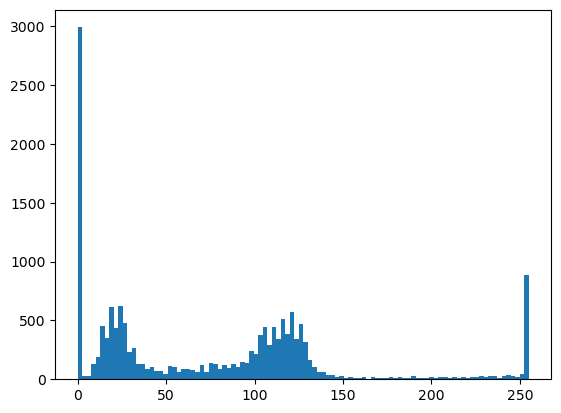

In [27]:
# See the pixel values division in the images
hist_plot(gray_image)

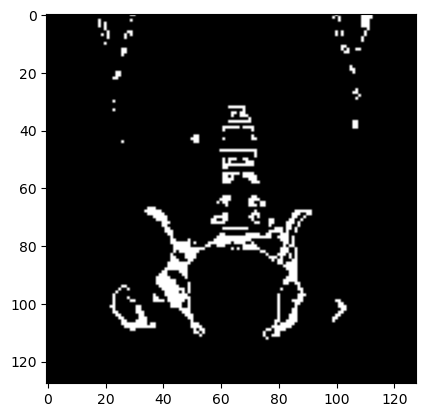

In [29]:
# Manual Thresholding on the basis of pixel divisions
img = threshold(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

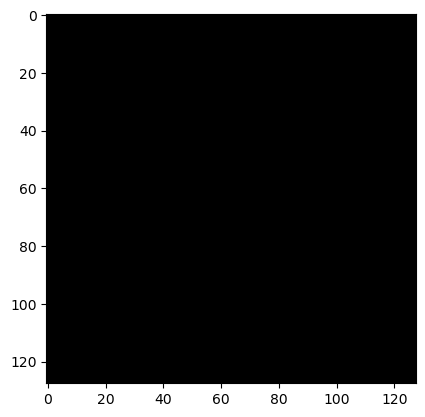

In [30]:
# HSV or Hue Saturation Value is used to separate image luminance from color information. This makes it easier when we are working on or need luminance of the image/frame. HSV also used in situations where color description plays an integral role.
# Hue, in the context of color and graphics, refers to the attribute of a visible light due to which it is differentiated from or similar to the primary colors
# Saturation describes the intensity of the color.
# Hue is determined by the dominant wavelength of the visible spectrum. It is the attribute that permits colors to be classified as red, yellow, green, blue, or an intermediate color. Saturation pertains the amount of white light mixed with a hue.
# Value works in conjunction with saturation and describes the brightness or intensity of the color, from 0 to 100 percent, where 0 is completely black, and 100 is the brightest and reveals the most color.

lower_yellow = np.array([35, 255, 255])
upper_yellow = np.array([25, 50, 70])
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
lower_white = np.array([180, 18, 255])
upper_white = np.array([0, 0, 231])
lower_black = np.array([180, 255, 30])
upper_black = np.array([0, 0, 0])

bgr_image = cv2.cvtColor(Features[143,:,:][:,:,0], cv2.COLOR_GRAY2BGR)

hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_black, upper_black)

detected_output = cv2.bitwise_and(hsv, hsv, mask =  mask)
plt.imshow(detected_output, cmap = "gray")
plt.show()

In [31]:
# Crop all the input images
Cropped_Features = []
for i in range(len(Features)):
    cropped_image = crop(Features[i,:,:,:])
    Cropped_Features.append(cropped_image)
Cropped_Features = np.array(Cropped_Features)

In [34]:
# Denoise all the input images

# On original images
bil_de = []
for i in range(len(Features)):
    bilateral_de = cv2.bilateralFilter(Features[i], 15, 75, 75)
    bil_de.append(bilateral_de)
bil_de = np.array(bil_de)


# On cropped images
bilateral_denoised = []
for i in range(len(Cropped_Features)):
    bilateral = cv2.bilateralFilter(Cropped_Features[i], 15, 75, 75)
    bilateral_denoised.append(bilateral)
bilateral_denoised = np.array(bilateral_denoised)

In [35]:
# Threshold masking on all the input images

# Original
thresholded = []
for i in range(len(bilateral_denoised)):
    temp = threshold(bilateral_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)


# Cropped
thresholded = []
for i in range(len(Cropped_Features)):
    temp = threshold(Cropped_Features[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)

In [36]:
print("SPLITTING DATA")

SPLITTING DATA


In [38]:
print(Features.shape)
print(Labels.shape)


(1453, 128, 128, 3)
(1453,)


In [39]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Features, Labels, test_size = 0.30, random_state = 80, shuffle = True)

print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

# Converting the list to a numpy array as a requirement for the input in fit function.
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)

1017 436 1017 436


In [40]:
from tensorflow.keras.optimizers import SGD

In [41]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3), padding='same'))
model3.add(MaxPool2D(2))
model3.add(Dropout(0.2))

model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.4))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.5))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.6))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

In [115]:
##CONVOLUTIONAL NEURAL NETWORK(CNN)

In [42]:

# Define a callback for early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

# Train the model
history = model3.fit(Xtrain, Ytrain, epochs = 200, batch_size = 20, callbacks = [early_stopping])


#To this function, we pass in the test samples x, specify a batch_size, and specify which level of verbosity we want from log messages during prediction generation. The output from the predictions won't be relevant for us, so we're setting verbose=0 for no output.
#Note that, unlike with training and validation sets, we do not pass the labels of the test set to the model during the inference stage.
predictions = model3.predict(x = Xtest, batch_size = 20, verbose = 0)
Accuracy = model3.evaluate(Xtest, Ytest, verbose = 0)
print("Accuracy: ", Accuracy[1] * 100)

Epoch 1/200
51/51 [==============================] - 24s 428ms/step - loss: 3.9012 - accuracy: 0.5300
Epoch 2/200
51/51 [==============================] - 19s 368ms/step - loss: 0.6886 - accuracy: 0.5585
Epoch 3/200
51/51 [==============================] - 21s 420ms/step - loss: 0.6895 - accuracy: 0.5644
Epoch 4/200
51/51 [==============================] - 29s 570ms/step - loss: 0.6854 - accuracy: 0.5674
Epoch 5/200
51/51 [==============================] - 19s 365ms/step - loss: 0.6872 - accuracy: 0.5772
Epoch 6/200
51/51 [==============================] - 19s 365ms/step - loss: 0.6868 - accuracy: 0.5664
Epoch 7/200
51/51 [==============================] - 25s 497ms/step - loss: 0.6919 - accuracy: 0.5634
Epoch 8/200
51/51 [==============================] - 33s 643ms/step - loss: 0.6827 - accuracy: 0.5713
Epoch 9/200
51/51 [==============================] - 29s 553ms/step - loss: 0.6839 - accuracy: 0.5595
Epoch 10/200
51/51 [==============================] - 23s 454ms/step - loss: 0.688

51/51 [==============================] - 21s 402ms/step - loss: 0.6702 - accuracy: 0.6106
Epoch 28/200
51/51 [==============================] - 20s 395ms/step - loss: 0.6643 - accuracy: 0.6136
Epoch 29/200
51/51 [==============================] - 19s 377ms/step - loss: 0.6681 - accuracy: 0.6155
Epoch 30/200
51/51 [==============================] - 19s 379ms/step - loss: 0.6651 - accuracy: 0.5880
Epoch 31/200
51/51 [==============================] - 19s 379ms/step - loss: 0.6685 - accuracy: 0.5880
Epoch 32/200
51/51 [==============================] - 20s 384ms/step - loss: 0.6608 - accuracy: 0.5998
Epoch 33/200
51/51 [==============================] - 22s 425ms/step - loss: 0.6534 - accuracy: 0.6165
Epoch 34/200
51/51 [==============================] - 20s 391ms/step - loss: 0.6504 - accuracy: 0.6264
Epoch 35/200
51/51 [==============================] - 21s 412ms/step - loss: 0.6491 - accuracy: 0.6244
Epoch 36/200
51/51 [==============================] - 20s 394ms/step - loss: 0.6405 - 

51/51 [==============================] - 36s 701ms/step - loss: 0.5792 - accuracy: 0.6824
Epoch 54/200
51/51 [==============================] - 29s 565ms/step - loss: 0.5944 - accuracy: 0.6981
Epoch 55/200
51/51 [==============================] - 32s 627ms/step - loss: 0.5739 - accuracy: 0.7011
Epoch 56/200
51/51 [==============================] - 30s 591ms/step - loss: 0.5548 - accuracy: 0.7021
Epoch 57/200
51/51 [==============================] - 34s 662ms/step - loss: 0.5558 - accuracy: 0.7129
Epoch 58/200
51/51 [==============================] - 29s 564ms/step - loss: 0.5718 - accuracy: 0.7050
Epoch 59/200
51/51 [==============================] - 28s 555ms/step - loss: 0.5623 - accuracy: 0.7119
Epoch 60/200
51/51 [==============================] - 28s 549ms/step - loss: 0.5473 - accuracy: 0.7129
Epoch 61/200
51/51 [==============================] - 29s 574ms/step - loss: 0.5376 - accuracy: 0.7217
Epoch 62/200
51/51 [==============================] - 28s 546ms/step - loss: 0.5106 - 

51/51 [==============================] - 28s 552ms/step - loss: 0.3927 - accuracy: 0.8299
Epoch 80/200
51/51 [==============================] - 28s 554ms/step - loss: 0.4190 - accuracy: 0.8083
Epoch 81/200
51/51 [==============================] - 28s 546ms/step - loss: 0.3678 - accuracy: 0.8407
Epoch 82/200
51/51 [==============================] - 28s 549ms/step - loss: 0.3984 - accuracy: 0.8092
Epoch 83/200
51/51 [==============================] - 29s 573ms/step - loss: 0.3688 - accuracy: 0.8358
Epoch 84/200
51/51 [==============================] - 29s 573ms/step - loss: 0.3962 - accuracy: 0.8279
Epoch 85/200
51/51 [==============================] - 29s 567ms/step - loss: 0.3433 - accuracy: 0.8545
Epoch 86/200
51/51 [==============================] - 30s 596ms/step - loss: 0.3610 - accuracy: 0.8387
Epoch 87/200
51/51 [==============================] - 29s 573ms/step - loss: 0.3353 - accuracy: 0.8584
Epoch 88/200
51/51 [==============================] - 29s 569ms/step - loss: 0.3448 - 

51/51 [==============================] - 29s 559ms/step - loss: 0.2679 - accuracy: 0.8928
Epoch 106/200
51/51 [==============================] - 28s 558ms/step - loss: 0.2396 - accuracy: 0.9105
Epoch 107/200
51/51 [==============================] - 29s 561ms/step - loss: 0.2588 - accuracy: 0.8909
Epoch 108/200
51/51 [==============================] - 29s 559ms/step - loss: 0.2503 - accuracy: 0.8948
Epoch 109/200
51/51 [==============================] - 29s 563ms/step - loss: 0.1775 - accuracy: 0.9263
Epoch 110/200
51/51 [==============================] - 29s 562ms/step - loss: 0.1695 - accuracy: 0.9282
Epoch 111/200
51/51 [==============================] - 28s 556ms/step - loss: 0.2180 - accuracy: 0.9243
Epoch 112/200
51/51 [==============================] - 29s 559ms/step - loss: 0.2057 - accuracy: 0.9213
Epoch 113/200
51/51 [==============================] - 29s 559ms/step - loss: 0.1872 - accuracy: 0.9272
Epoch 114/200
51/51 [==============================] - 31s 613ms/step - loss: 

51/51 [==============================] - 28s 549ms/step - loss: 0.1454 - accuracy: 0.9420
Epoch 132/200
51/51 [==============================] - 28s 548ms/step - loss: 0.1164 - accuracy: 0.9528
Epoch 133/200
51/51 [==============================] - 28s 545ms/step - loss: 0.1351 - accuracy: 0.9469
Epoch 134/200
51/51 [==============================] - 28s 546ms/step - loss: 0.1355 - accuracy: 0.9597
Epoch 135/200
51/51 [==============================] - 28s 544ms/step - loss: 0.1525 - accuracy: 0.9410
Epoch 136/200
51/51 [==============================] - 28s 542ms/step - loss: 0.1158 - accuracy: 0.9508
Epoch 137/200
51/51 [==============================] - 28s 548ms/step - loss: 0.1048 - accuracy: 0.9558
Epoch 138/200
51/51 [==============================] - 28s 547ms/step - loss: 0.1282 - accuracy: 0.9528
Epoch 139/200
51/51 [==============================] - 28s 551ms/step - loss: 0.1396 - accuracy: 0.9548
Epoch 140/200
51/51 [==============================] - 28s 543ms/step - loss: 

51/51 [==============================] - 28s 541ms/step - loss: 0.0796 - accuracy: 0.9735
Epoch 158/200
51/51 [==============================] - 28s 541ms/step - loss: 0.0928 - accuracy: 0.9695
Epoch 159/200
51/51 [==============================] - 28s 546ms/step - loss: 0.0609 - accuracy: 0.9774
Epoch 160/200
51/51 [==============================] - 28s 548ms/step - loss: 0.0713 - accuracy: 0.9735
Epoch 161/200
51/51 [==============================] - 28s 544ms/step - loss: 0.0926 - accuracy: 0.9617
Epoch 162/200
51/51 [==============================] - 28s 542ms/step - loss: 0.1479 - accuracy: 0.9518
Epoch 163/200
51/51 [==============================] - 28s 543ms/step - loss: 0.1364 - accuracy: 0.9587
Epoch 164/200
51/51 [==============================] - 28s 542ms/step - loss: 0.0810 - accuracy: 0.9715
Epoch 165/200
51/51 [==============================] - 28s 545ms/step - loss: 0.0702 - accuracy: 0.9744
Epoch 166/200
51/51 [==============================] - 28s 543ms/step - loss: 

51/51 [==============================] - 28s 540ms/step - loss: 0.0546 - accuracy: 0.9803
Epoch 184/200
51/51 [==============================] - 28s 541ms/step - loss: 0.0464 - accuracy: 0.9813
Epoch 185/200
51/51 [==============================] - 27s 538ms/step - loss: 0.0707 - accuracy: 0.9794
Epoch 186/200
51/51 [==============================] - 28s 544ms/step - loss: 0.1020 - accuracy: 0.9617
Epoch 187/200
51/51 [==============================] - 28s 540ms/step - loss: 0.1023 - accuracy: 0.9676
Epoch 188/200
51/51 [==============================] - 27s 537ms/step - loss: 0.0749 - accuracy: 0.9813
Epoch 189/200
51/51 [==============================] - 28s 543ms/step - loss: 0.1073 - accuracy: 0.9567
Epoch 190/200
51/51 [==============================] - 28s 542ms/step - loss: 0.0679 - accuracy: 0.9715
Epoch 191/200
51/51 [==============================] - 28s 540ms/step - loss: 0.0785 - accuracy: 0.9725
Epoch 192/200
51/51 [==============================] - 28s 545ms/step - loss: 

In [118]:
"""import numpy as np
from sklearn.metrics import confusion_matrix

# ...

# Train the model
history = model3.fit(Xtrain, Ytrain, epochs=200, batch_size=20, callbacks=[early_stopping])

predictions = model3.predict(x=Xtest, batch_size=20, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(Ytest, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion)

accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Accuracy: {:.2f}%".format(accuracy * 100))"""


'import numpy as np\nfrom sklearn.metrics import confusion_matrix\n\n# ...\n\n# Train the model\nhistory = model3.fit(Xtrain, Ytrain, epochs=200, batch_size=20, callbacks=[early_stopping])\n\npredictions = model3.predict(x=Xtest, batch_size=20, verbose=0)\npredicted_labels = np.argmax(predictions, axis=1)\ntrue_labels = np.argmax(Ytest, axis=1)\n\n# Compute the confusion matrix\nconfusion = confusion_matrix(true_labels, predicted_labels)\nprint("Confusion Matrix:")\nprint(confusion)\n\naccuracy = np.sum(np.diag(confusion)) / np.sum(confusion)\nprint("Accuracy: {:.2f}%".format(accuracy * 100))'

In [119]:
##SVM classifier for comparision

In [43]:
Xtrain.shape

(1017, 128, 128, 3)

In [44]:
Xtest.shape

(436, 128, 128, 3)

In [45]:
Xtrain_SVC = Xtrain.reshape(1017, 128 * 128 * 3)
Xtest_SVC = Xtest.reshape(436, 128 * 128 * 3)

In [46]:
model_SVC = SVC(C = 1,kernel='poly',gamma = 'auto')
model_SVC.fit(Xtrain_SVC, Ytrain)

SVC(C=1, gamma='auto', kernel='poly')

In [125]:
prediction = model_SVC.predict(Xtest_SVC)
accuracy = model_SVC.score(Xtest_SVC , Ytest)

In [126]:
train_accuracy = model_SVC.score(Xtrain_SVC, Ytrain)
print("Train_Accuracy", train_accuracy * 100)

Train_Accuracy 100.0


In [127]:
print("Test_Accuracy ",accuracy * 100)

Test_Accuracy  91.97247706422019


In [128]:
# cm = confusion_matrix(y_true = Ytest, y_pred = np.argmax(predictions,axis=-1))
cm = confusion_matrix(Ytest , (prediction > 0.75) * 1)

In [129]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[160  30]
 [  5 241]]


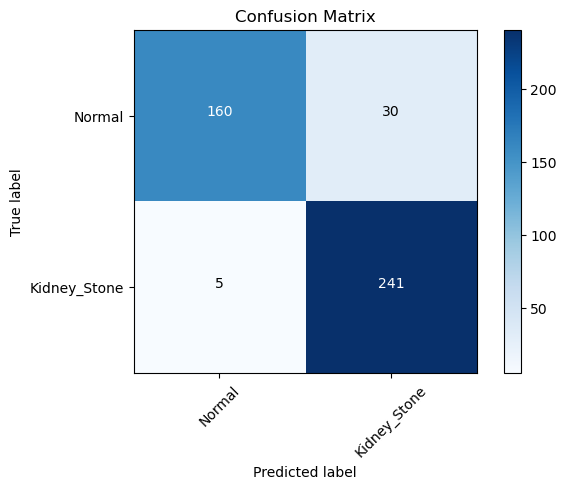

In [130]:
cm_plot_labels = ['Normal','Kidney_Stone']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [131]:
##PREDICTION

In [47]:
def image_prediction(img):
    plt.imshow(img)
    img1=img.reshape(1,128,128,3)
    predict = model3.predict(img1)
    if ((predict > 0.75) * 1):
        print("The condition is normal and stable.")
    else:
        print("Person is having kidney stone(s)")

1/1 [==============================] - 0s 31ms/step
Person is having kidney stone(s)


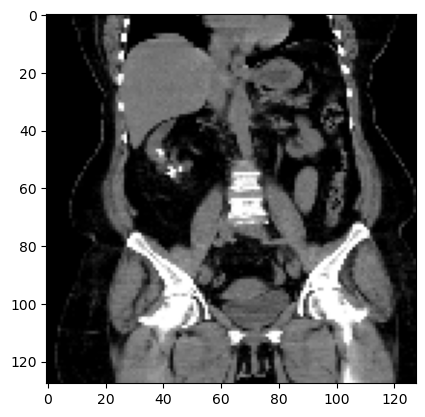

In [52]:
image_prediction(Xtest[20])

In [137]:
!pip install split-folders

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


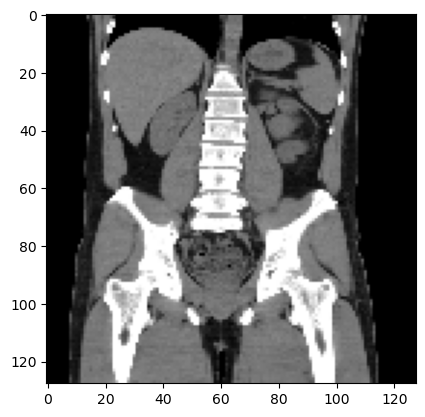

In [141]:
path_2 = "C:/Users/Akshay Bhagwat/Desktop/projects/DIP/Dataset/Normal/1n.png"
image_array_2 = cv2.imread(path_2)
new_image_2 = cv2.resize(image_array_2,(128,128))
plt.imshow(new_image_2)
plt.show()

In [145]:
model3.save('kidney_stones_model.h5')

In [ ]:
'''def image_prediction_KMeans(img):
    img = img.reshape(128,128,3)
    plt.imshow(img)
    img1 = img.reshape(1, 128 * 128 * 3)
    predict = kmeans_model.predict(img1)
    print(predict)
    if (predict):
        print("Person is having kidney stone(s)")
    else:
        print("The condition is normal and stable.")'''